# ASTR 596: FDS - The Midterm

__Edited by: Alex Gagliano__

__Date: March 22nd, 2020__

### Dun, dun dun. 
#### (suspenseful music here)

## Start with the Cepheid data you have already seen in lecture 03 and 04.

## There are measurements of several Cepheid variable stars in each of 9 nearby galaxies.

## Begin by reading this code and familiarizing yourself with what attributes and functions are available to you. In particular, it will help to read comments at the top of the data file.

In [194]:
import numpy as np
import scipy.stats as st
from matplotlib import pyplot as plt
import scipy.optimize
from astroML.datasets import fetch_hogg2010test
import pymc3 as pm
cols =  ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
exec(open('cepheids.py').read())
ceph = Cepheids('../../data/03/R11ceph.dat')
hosts = ceph.list_hosts()

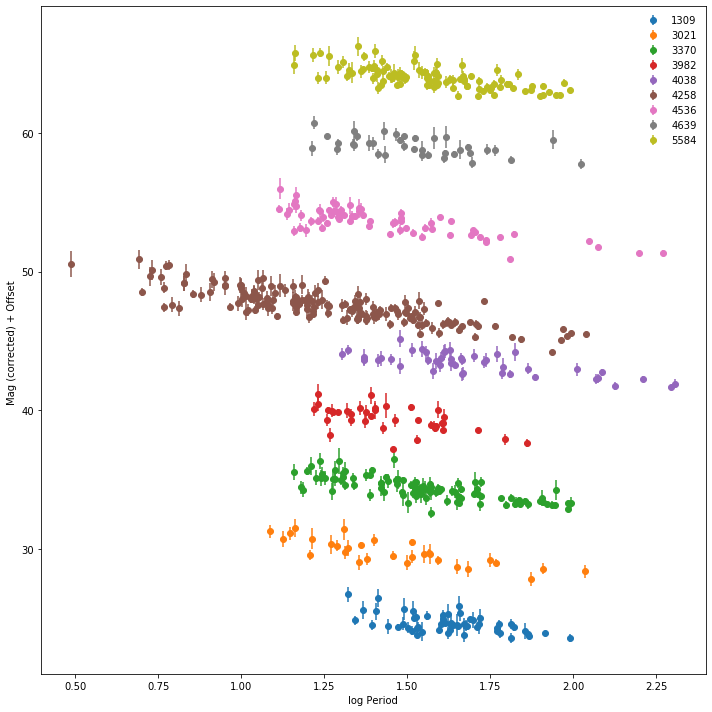

In [195]:
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
mtrue = []
Ptrue = []
sigtrue = []

for i, ID in enumerate(hosts):
    ceph.select(ID)
    mobs = ceph.mobs
    logP = ceph.logP
    sigma_obs = ceph.sigma
    mtrue.append(mobs)
    Ptrue.append(logP)
    sigtrue.append(sigma_obs)
    ax.errorbar(logP, mobs+(5*i), yerr=sigma_obs, linestyle='None', marker='o', c=cols[i], label=ID)
    
mtrue = np.array(mtrue)
Ptrue = np.array(Ptrue)
sigtrue = np.array(sigtrue)

ax.legend(frameon=False)
ax.set_xlabel('log Period')
ax.set_ylabel('Mag (corrected) + Offset ')
fig.tight_layout()

# Q1.

## This data was taken from [Riess et al., 2011](https://arxiv.org/abs/1103.2976)

## The global model for the magnitudes of these Cepheids is given in Equation 1. You may ignore the effect of metalicity

## Some parameters (such as distance modulus) are specific to each galaxy.

## Others are common to all galaxies. 

## Assuming Gaussian magnitude errors and no period (and you may ignore metallicity entirely), but that Cepheids scatter off the period-luminosity relation because of some Gaussian intrinsic dispersion $\sigma_{\text{int}}$, write down your expression for the likelihood being careful to use the same indices that Riess et. al used.


### My expression for the likelihood is as follows: 

$$L = e^{-\chi^2/2} = e^{-\sum_{i} \sum_{j} \frac{(model_{i,j} - true_{i,j})^2}{(sigma_{i,j})^2} }  = e^{-\sum_{i} \sum_{j} \frac{((\mu_{0,i} - \mu_{0,4258}) + zp_{W,4258} + b_W log(P_{i,j}) - m_{i,j})^2}{(\sigma_{i,j}^2 + \sigma_{int}^2)} }$$
### This makes the log-likelihood: 
$$\mathcal{L} = -log(L) = \chi^2/2 = \sum_{i} \sum_{j} \frac{(model_{i,j} - true_{i,j})^2}{(\sigma_{i,j})^2}   = \sum_{i} \sum_{j} \frac{((\mu_{0,i} - \mu_{0,4258}) + zp_{W,4258} + b_W log(P_{i,j}) - m_{i,j})^2}{\sigma_{int}^2 + \sigma_{i,j}^2}$$

We code this up below.

# Q2. 

## Given what you know for each of the parameters in this model, write down physically motivated (i.e. not just top hats on everything) priors, along with your explanation.

## Think particularly about the priors for distances to each galaxy.

The easiest way to come up with priors would probably be to get the best guess estimates of each parameter from the data, and then to encode physical information about each value into our prior distributions (with mean as the best guess). Looking at the data: 

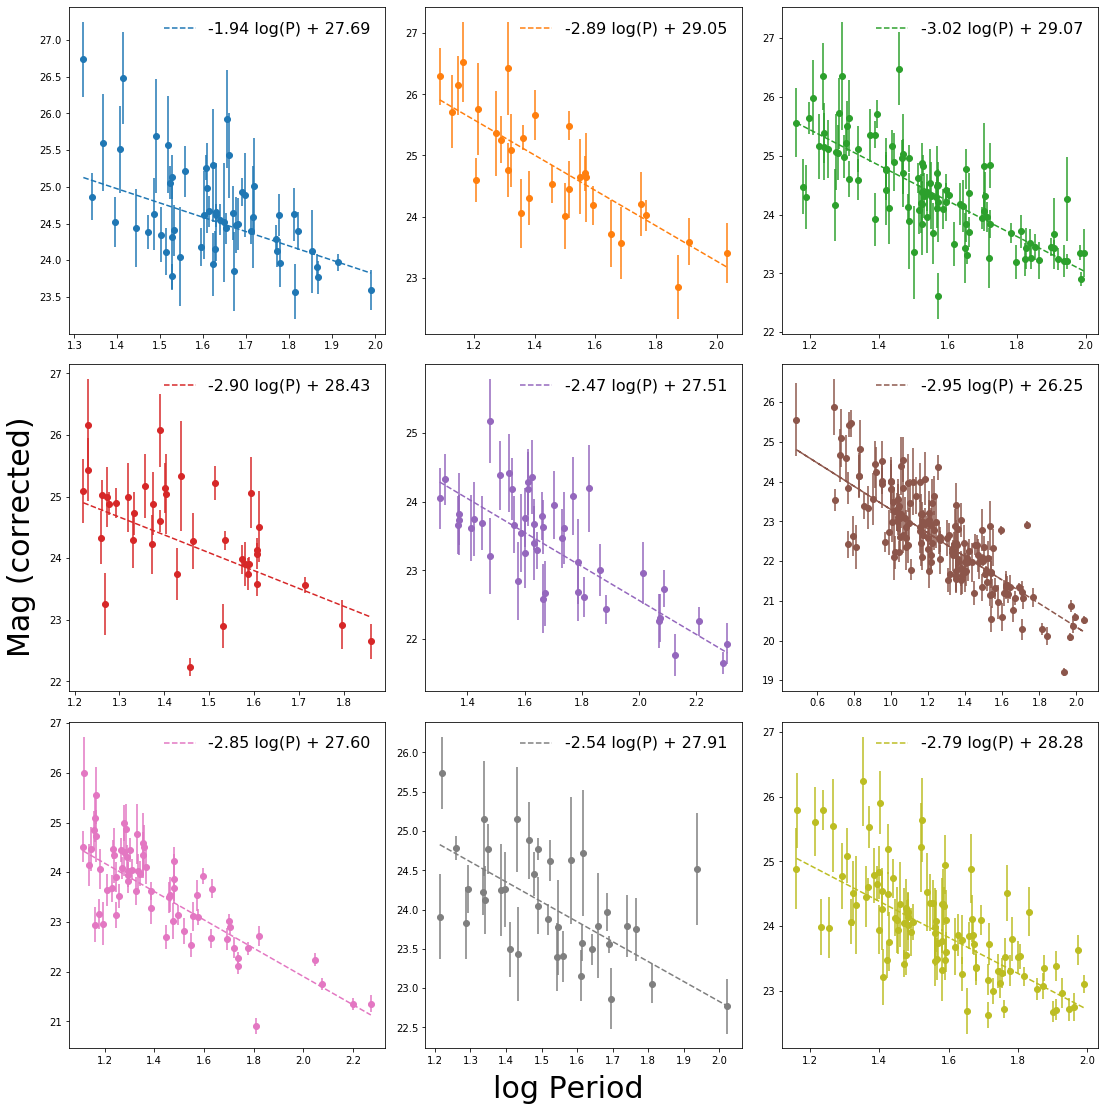

In [196]:
from scipy.optimize import minimize
global sig_int
sig_int = 0.1

def meanMag(theta, Ptrue):
    mW = theta[2] + theta[1] + theta[0] * Ptrue
    return mW

# the log-likelihood for a single galaxy
def log_likelihood(theta, mtrue, Ptrue, sig_true):
    chisq = np.sum((meanMag(theta, Ptrue) - mtrue)**2/(sig_true**2+sig_int**2))
    return 0.5*chisq

# quick hack to get the minimizer function to minimize over an array of input variables
nll = lambda *args: log_likelihood(*args)

#set up subplots
fig, ax = plt.subplots(3, 3, sharex=False, sharey=False)

fig.set_figheight(15)
fig.set_figwidth(15)
bW_init = []
mu_init = []
zp_init = []
#our starting guesses for bW, mu, and zp for each galaxy
initial = [-5, 0, 25]

#do the optimizing and the plotting
for i in range(3):
    for j in range(3):
        ID = hosts[i*3+j]
        ceph.select(ID)
        mobs = ceph.mobs
        logP = ceph.logP
        sigma_obs = ceph.sigma
        soln = minimize(nll, initial, args=(mobs, logP, sigma_obs))
        bW = soln.x[0]
        mu = soln.x[1]
        zp = soln.x[2]
        bW_init.append(bW)
        mu_init.append(mu)
        zp_init.append(zp)
        ax[i,j].plot(logP, bW*logP+mu+zp, '--', label='%.2f log(P) + %.2f'%(bW,mu+zp),c=cols[i*3+j])
        ax[i,j].errorbar(logP, mobs, yerr=sigma_obs, linestyle='None', marker='o', c=cols[i*3+j])
        ax[i,j].legend(frameon=False,fontsize=16)
fig.text(0.5, -0.02, 'log Period', ha='center',fontsize=30)
fig.text(-0.02, 0.5, 'Mag (corrected)', va='center', rotation='vertical',fontsize=30)
fig.tight_layout()

We now have our best fit parameters for the slope and the intercept of each galaxy, taking into account the errors on the points. Our model is:$$ m_{W_{i,j}} = (\mu_{0,i} - \mu_{0,4258}) + zp_{W,4258} + b_W log(P_{i,j})$$
Our values for $ \mu_{0,4258}$, $zp_{W,4258}$, and $b_W $ should be identical for each galaxy, which means the value of the slope $b_W$ should be constant between galaxy fits. Let's look at the distribution of values:

In [197]:
np.median(mu_init)

1.4535725561124204

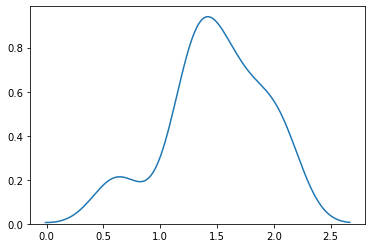

In [198]:
import seaborn as sns
sns.kdeplot(mu_init)

Assuming galaxy 4258 is the closest galaxy in the set, since it's the reference, let's say that $\mu_{0,i} - \mu_{0,4258}$ must be positive. The range of values are from 0 and about 2.5 from the kde plot above - let's extend it to 5 to be safe. It's clear that our slope should be negative, which also makes sense from a physical standpoint - dimmer cepheids pulse faster. To see where we should estimate our slope, let's take the median of the above slope fits:

In [199]:
np.median(bW_init)

-2.84763248358526

And look at the full range of values:

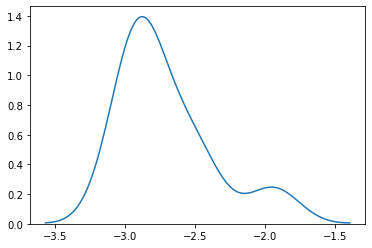

In [200]:
sns.kdeplot(bW_init)

So we'll extend our range from maybe -5 to 0. For our estimated distance modulus to NGC 4258, we'll start with a guess of:

In [201]:
np.median(zp_init)

26.453572556112253

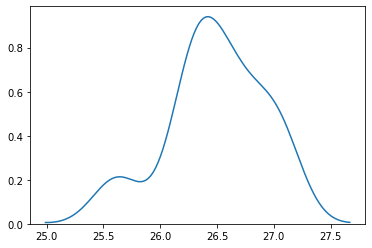

In [202]:
sns.kdeplot(zp_init)

From this plot, we'll set the range for $zp$, the nuisance parameter representing NGC 4528's distance modulus, as between 25 and 30. We know as a distance that this has to be a positive value anyway. Coding all this up into priors, we get:

In [203]:
# i is the host number and j is the cepheid number
# mW_{i,j} = (mu_{0,i} - mu_{0,4258}) + zp_{W,4258} + b_W * log(P_{i,j}) + Z_W * dlog10(O/H)_{i,j}
# ignoring metallicity, we get 
# mW_{i,j} = (mu_{0,i} - mu_{0,4258}) + zp_{W,4258} + b_W * log(P_{i,j})
#
# zp_{W,4258} : the intercept for the period-luminosity relation from NGC4258
# mu_{0,i} : the distance modulus from host i
# and mu_{0,4258} is the distance modulus from NGC4528

# mean of the slopes as the guess for bW, intercepts as guess for mu0,i - mu0,4258
# with 0 as the guess for zpW,4258
theta_init = np.append(np.median(bW_init), mu_init)
theta_init = np.append(theta_init, np.median(zp_init))

While I'm running my MCMC, I'm removing the difference $\mu_{0,i} - \mu_{0,4258}$  for galaxy 6 - NGC4258 - as a fitted parameter because it should be 0. Including it will just introduce one more knob to tweak that we don't need.

In [204]:
theta_init = np.delete(theta_init, [6])

In [205]:
# the log-likelihood for all galaxies simultaneously
def neg_log_likelihood_all(theta, mtrue, Ptrue, sig_true):    
    chisq = np.zeros(9)
    for i in np.arange(9):
        # a little funky business on the theta array to read the slope bw, intercept, and zp
        chisq[i] = np.sum((meanMag(theta[[0,i+1,-1]], Ptrue[i]) - mtrue[i])**2/(sig_true[i]**2+sig_int**2))
    return -0.5*np.sum(chisq)

# the log of the prior for the slope and the intercept of our lines.
# only if the prior makes sense for all lines simultaneously do we 
# accept it
def log_prior(theta):
    prior = np.zeros(9)
    bW = theta[0]
    zp = theta[-1]
    for i in np.arange(9):   
        mu = theta[1+i]
        logprior_bW = logprior_mu = logprior_zp = -np.inf
        if -5<bW<0 and 0<=mu<5 and 25<zp<30:
            logprior_bW=logprior_mu=logprior_zp=0
        prior[i] = logprior_bW+logprior_mu+logprior_zp
    return np.sum(prior)

# the posterior is the combination of the prior and the likelihood for each of our 9 galaxies, simultaneously fit
def log_posterior(theta, Ptrue, mtrue, sig_true):
    # add in the 0 y-intercept for galaxy NGC 4258 - theta doesn't leave this function after this
    # so we're fine
    newTheta = np.insert(theta, 6, [0])
    return log_prior(newTheta)+neg_log_likelihood_all(newTheta, mtrue, Ptrue, sig_true) 

Note that we've stacked all the observations and initial parameters so that we can do a simultaneous fit, instead of fitting each of the params separately. This also required us to define a new log likelihood for all galaxies, in order to sum over both $i$ and $j$ as described in question 1. 

# Q3. 

## Implement this likelihood and prior in python and sample the posterior distribution with emcee.

## Construct traceplots for each parameter, as well as corner plots for each pair of parameters.


## If your Markov Chains are reasonable, verify that your model fits are reasonable by reconstructing Fig. 7 of Riess et al. 2011

## Compare the intercept you find for the intercepts $\mu_{0,i} - \mu_{0, 4258}$ vs Table 3 of Riess et al. 2011

In [206]:
import emcee
pos = theta_init + 1.e-1*np.random.randn(1000, 10)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(Ptrue, mtrue, sigtrue))
sampler.run_mcmc(pos, 1000, progress=True);

100%|██████████| 1000/1000 [06:29<00:00,  2.56it/s]


With our run complete, let's check out our data.

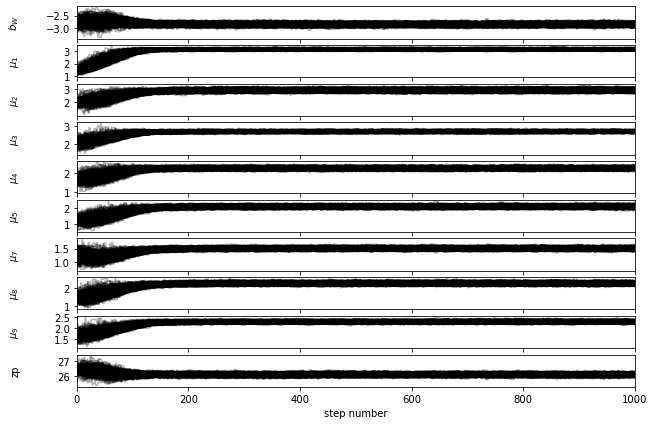

In [207]:
fig, axes = plt.subplots(10, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

labels = [r"$b_W$", "$\mu_1$", "$\mu_2$", "$\mu_3$", "$\mu_4$", "$\mu_5$", "$\mu_7$", "$\mu_8$", "$\mu_9$", "zp"]
for i in range(10):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");

We see a pretty clear burn-in period within the first ~200 steps, after which we're looking okay. Let's see how our $\mu_{0,i} - \mu_{0,4258}$ values compare to those given in table 3 of Reiss et al.:

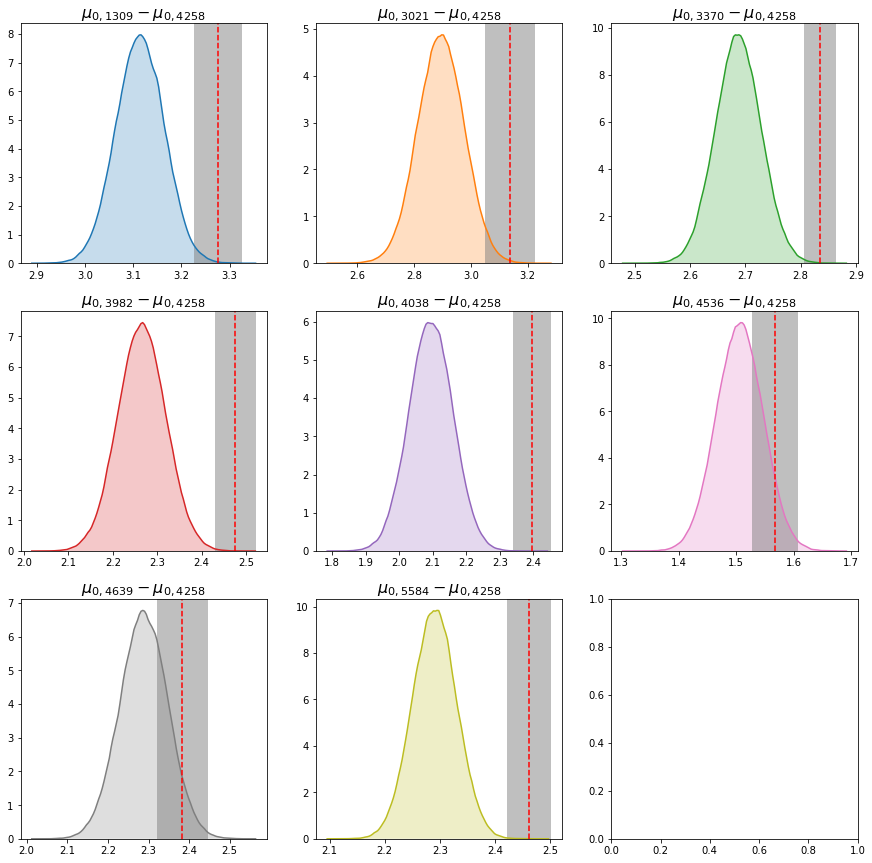

In [213]:
#remove 4258 from the host list - we didn't estimate the y-intercept for it.
hosts_no4258 = hosts[hosts!='4258']
cols = np.array(cols)
cols_no4258 =  cols[cols != 'tab:brown']

# remove the initial burn-in period and compare the plots to the slopes we get from table 3 of reiss et al.
samples_postBurnIn = samples[200:,:,:]
trueMu = {'4536':1.567, '4639':2.383, '3370':2.835, '3982':2.475, '3021':3.138, '1309':3.276, '5584':2.461, '4038':2.396}
trueMuErr = {'4536':0.0404, '4639':0.063, '3370':0.0284, '3982':0.046, '3021':0.087, '1309':0.0491, '5584':0.0401, '4038':0.0567}
fig, ax = plt.subplots(3,3, sharex=False, sharey=False)

fig.set_figheight(15)
fig.set_figwidth(15)
#do the optimizing and the plotting
for i in range(3):
    for j in range(3):
        idx = i*3+j
        if idx < 8:
            sns.kdeplot(samples_postBurnIn[:,:,idx+1].flatten(),ax=ax[i,j], shade=True, color=cols_no4258[idx])
            ax[i,j].set_title(r"$\mu_{0,%s} - \mu_{0,4258}$"%hosts_no4258[idx],fontsize=16)
            ax[i,j].axvline(x=trueMu[hosts_no4258[idx]],linestyle='--',c='r',label='Reiss et al., 2011')
            ax[i,j].axvspan(trueMu[hosts_no4258[idx]]-trueMuErr[hosts_no4258[idx]], trueMu[hosts_no4258[idx]]+trueMuErr[hosts_no4258[idx]], facecolor='grey', alpha=0.5)

So they're not perfect, but everyone has their faults okay? Let's see the corner plots:

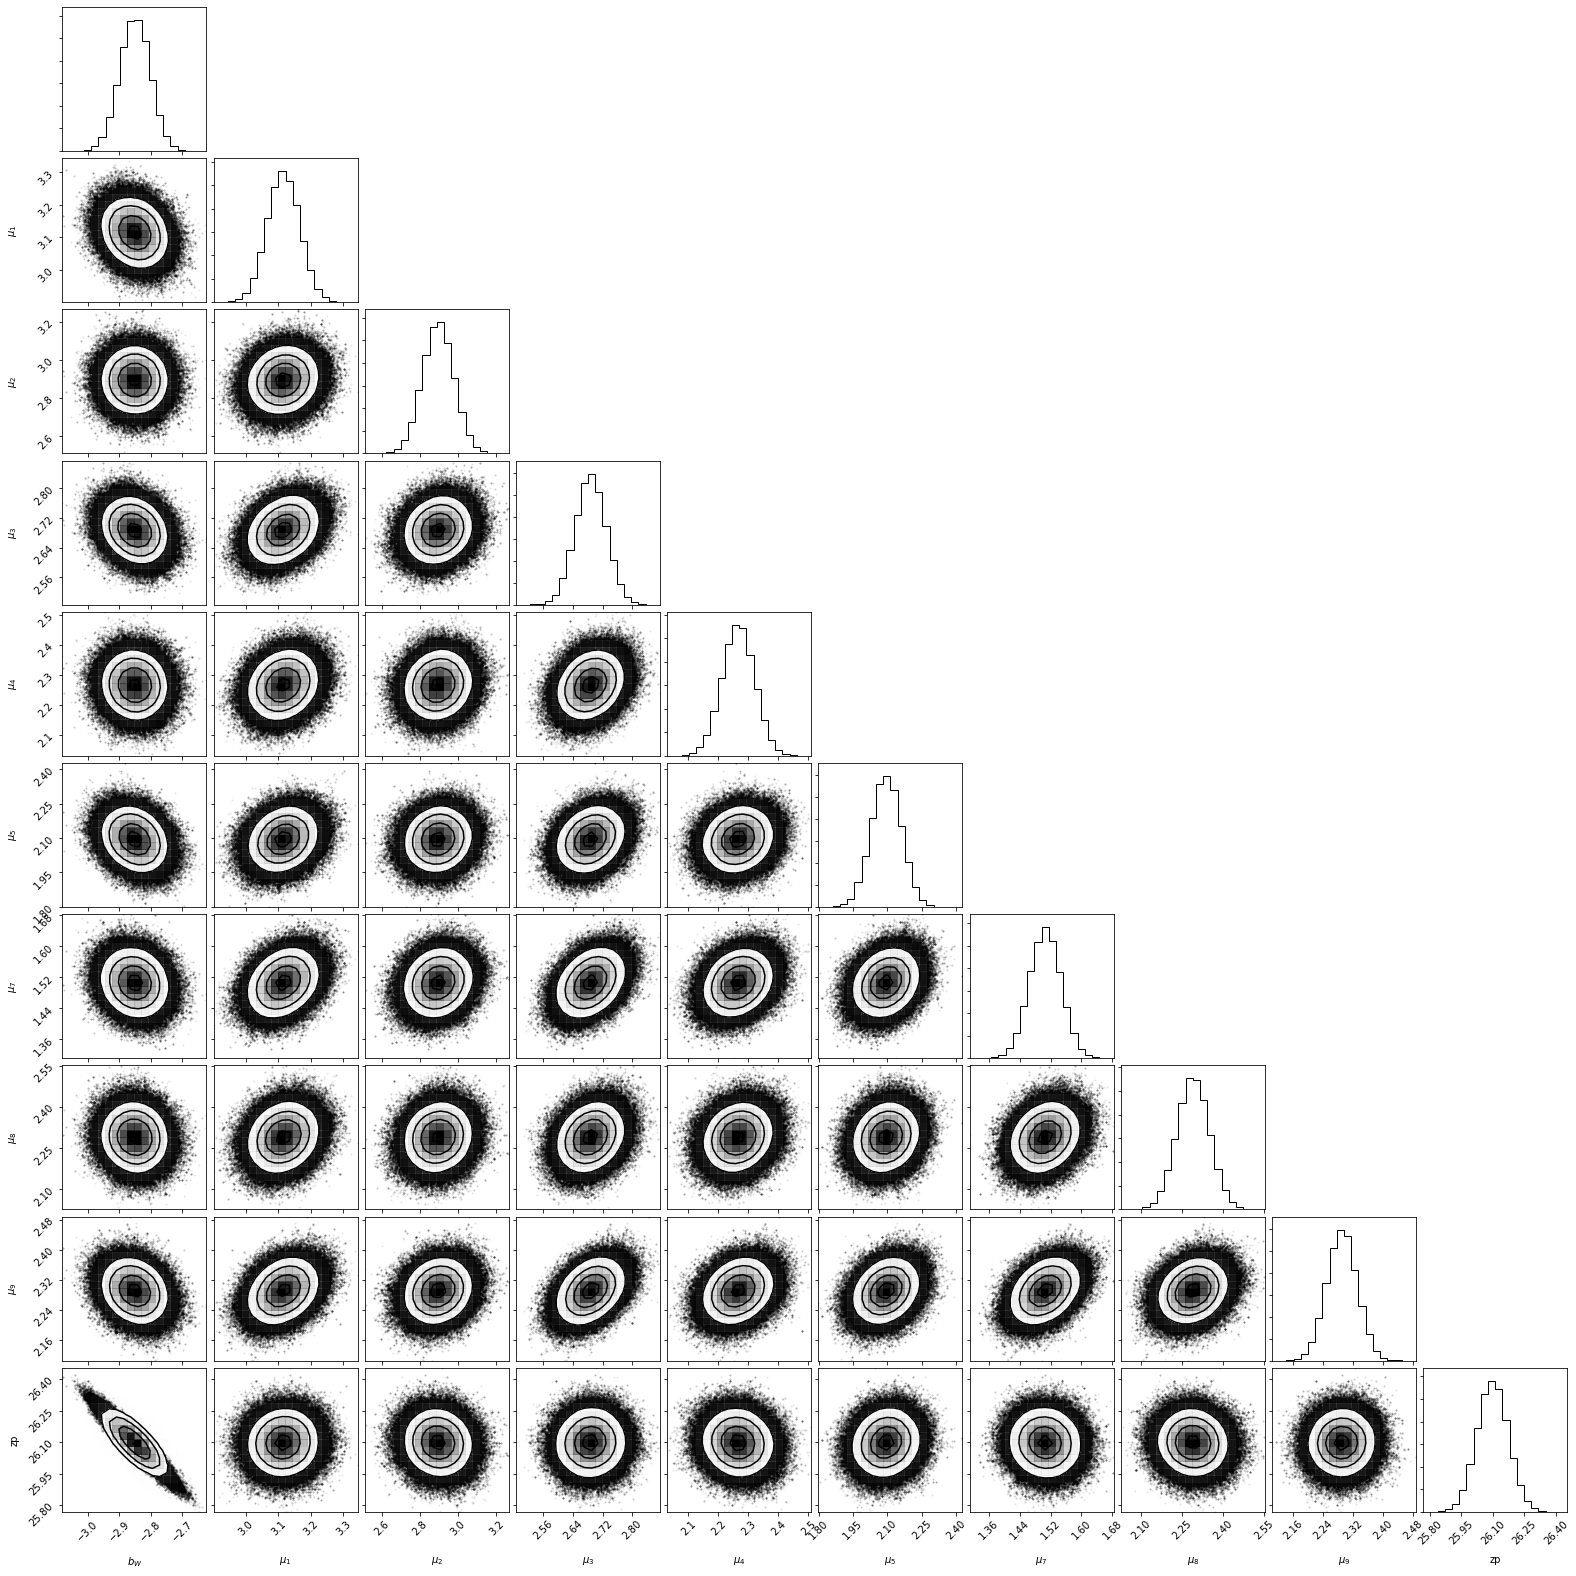

In [214]:
# show the full corner plot 
import corner
samples_post = samples_postBurnIn.reshape((-1, 10))
fig = corner.corner(samples_post, labels=labels,smooth=True);

We're not centered on the values found by Reiss et al., but darn it if those aren't some pretty multivariate distributions.

# Q4.

## Riess et al. do a *simultaneous* fit to the Cepheids and SNe data (Table 3 of their paper). 

## I'm slightly less cruel, so you can take your intercepts $\mu_{0,i} - \mu_{0, 4258}$ and the re-express equation 4 using a substitution of equation 3.

## Write that expression down.

$log H_0 = \frac{\left( m^0_{v,4258} - \mu_{0,4258} + 5 a_v + 25 \right)}{5} = \frac{\left( (m^0_{v,i} - (\mu_{0,i} - \mu_{0,4258})) - \mu_{0,4258} + 5 a_v + 25 \right)}{5} $

$\implies log H_0 =  \frac{m^0_{v,i}+ 5 a_v + 25  - (\mu_{0,i} - \mu_{0,4258}) - \mu_{0,4258}}{5} $

# Q5

## Using the supernova data in Table 3 (enter it into whatever data structure you deem best) and the distance modulus to NGC 4258 from [Humphreys et al., 2013 ](https://ui.adsabs.harvard.edu/abs/2013ApJ...775...13H/abstract) and using the simple sample statistics you learned in Week 1, estimate the Hubble constant.

Let's take the median (less sensitive to outliers, even though the trace plots look reasonably stationary and reversable) of each of our parameters after burn-in as the values to which we've converged.

In [215]:
diffmu = {}
for i in np.arange(8):
    diffmu[hosts_no4258[i]] = np.median(samples_postBurnIn[:,:,i+1].flatten())

In [216]:
#First, from Humphreys et al., 2013:
D4258 = 7.6e6 # pc
mu0_4258 = 5*np.log10(D4258/10)

#Next, the data from table 3: 
m0vi = {'4536':15.147, '4639':16.04, '3370':16.545, '3982':15.953, '3021':16.699, '1309':16.768, '5584':16.274, '4038':15.901}

H0_list = []
#Calculating the Hubble constant from here:
for host in hosts_no4258:
    logH0 = (m0vi[host] + 25 - diffmu[host] - mu0_4258)/5.0
    H0 = 10**logH0
    H0_list.append(H0)
H0 = np.array(H0_list)
H0_est = np.median(H0)
H0_err = np.std(H0)

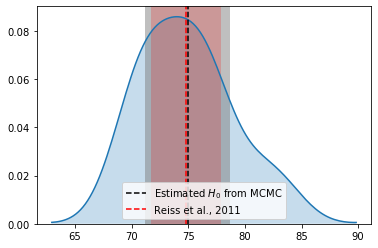

In [217]:
sns.kdeplot(H0, shade=True)
plt.axvline(x=H0_est, linestyle='--', color='k', label=r'Estimated $H_0$ from MCMC')
plt.axvline(x=74.8, linestyle='--', color='r', label='Reiss et al., 2011')
# plot a dashed line for the median
# plot a dashed line for the "true" value of the hubble constant, determined by Reiss et al
plt.axvspan(H0_est - H0_err, H0_est+H0_err, facecolor='grey', alpha=0.5)
plt.axvspan(74.8 - 3.1, 74.8 + 3.1, facecolor='r', alpha=0.2)
plt.legend();

Right on the money! Not too surprising, since we made use of the supernova data from the original paper plus a more thoroughly vetted value for $\mu_{0,4258}$. If we were to use OUR estimated value for the distance to NGC 4258, we'd be wayyyyy off:

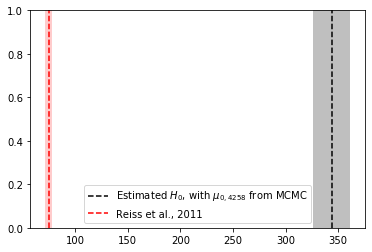

In [218]:
mu0_4258_MCMC = np.median(samples_postBurnIn[:,:,-1].flatten())
H0_list_MCMC = []
for host in hosts_no4258:
    logH0_MCMC = (m0vi[host] + 25 - diffmu[host] - mu0_4258_MCMC)/5.0
    H0_MCMC = 10**logH0_MCMC
    H0_list_MCMC.append(H0_MCMC)
H0_MCMC = np.array(H0_list_MCMC)
H0_est_MCMC = np.median(H0_MCMC)
H0_err_MCMC = np.std(H0_MCMC)

plt.axvline(x=H0_est_MCMC, linestyle='--', color='k', label=r'Estimated $H_0$, with $\mu_{0,4258}$ from MCMC')
plt.axvline(x=74.8, linestyle='--', color='r', label='Reiss et al., 2011')
# plot a dashed line for the median
# plot a dashed line for the "true" value of the hubble constant, determined by Reiss et al
plt.axvspan(H0_est_MCMC - H0_err_MCMC, H0_est_MCMC+H0_err_MCMC, facecolor='grey', alpha=0.5)
plt.axvspan(74.8 - 3.1, 74.8 + 3.1, facecolor='r', alpha=0.2)
plt.legend();

Our fitted value for $\mu_{0,4258}$ is quite a bit lower than the value given in Humphreys et al., 2013., causing the big difference in the $H_0$ value here. 